# Least-Squares Reverse Time Migration through Devito

@Author: Francesco Picetti - picettifrancesco@gmail.com


To use this notebook, we need devito installed. On your occamypy-ready env, run

```pip install --user git+https://github.com/devitocodes/devito.git```

In [1]:
import occamypy as o
import born_devito as b

# Plotting
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
rcParams.update({
    'image.cmap'     : 'gray',
    'image.aspect'   : 'auto',
    'image.interpolation': None,
    'axes.grid'      : False,
    'figure.figsize' : (10, 6),
    'savefig.dpi'    : 300,
    'axes.labelsize' : 14,
    'axes.titlesize' : 16,
    'font.size'      : 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex'    : True,
    'font.family'    : 'serif',
    'font.serif'     : 'Latin Modern Roman',
})

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


/Users/francesco/miniconda3/envs/occd/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


## Setup

In [2]:
args = dict(
    filter_sigma=(1, 1),
    spacing=(10., 10.),  # meters
    shape=(101, 101),    # samples
    nbl=20,              # samples
    nreceivers=51,
    src_x=[100,500,900], # meters
    src_depth=20.,       # meters
    rec_depth=30.,       # meters
    t0=0.,
    tn=2000.,            # Simulation lasts 2 second (in ms)
    f0=0.010,            # Source peak frequency is 10Hz (in kHz)
    space_order=5,
    kernel="OT2",
    src_type='Ricker',
    workers=3,
    chunks=(1,1,1),
)

In [3]:
def unpad(model, nbl: int = args["nbl"]):
    return model[nbl:-nbl, nbl:-nbl]

create hard model and migration model

In [4]:
model_true, model_smooth, water = b.create_models(args)
model = o.VectorNumpy(model_smooth.vp.data.__array__())
model.ax_info = [
    o.AxInfo(model_smooth.vp.shape[0], model_smooth.origin[0] - model_smooth.nbl * model_smooth.spacing[0],
             model_smooth.spacing[0], "x [m]"),
    o.AxInfo(model_smooth.vp.shape[1], model_smooth.origin[1] - model_smooth.nbl * model_smooth.spacing[1],
             model_smooth.spacing[1], "z [m]")]
model_extent = [0., 1000., 1000., 0.]

Define acquisition geometry

In [5]:
rec = b.build_rec_coordinates(model_true, args)

## Case 1: single shot

In [6]:
src = [b.build_src_coordinates(x, args["src_depth"]) for x in [500.]]

create the common shot gather (CSG) data

In [7]:
csg_nonlinear = b.propagate_shots(model=model_true, src_pos=src, rec_pos=rec, param=args)

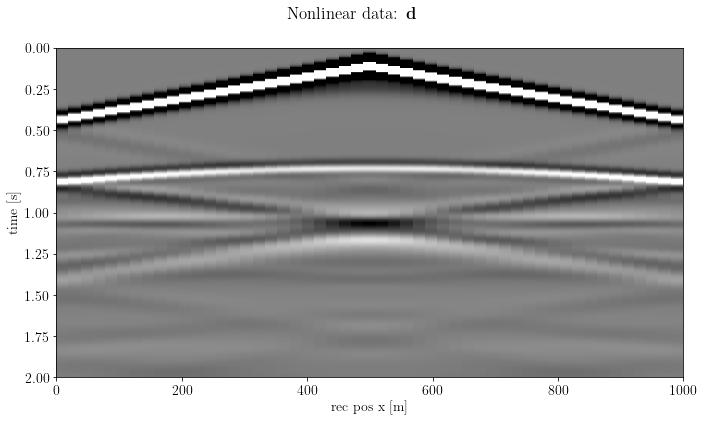

In [8]:
fig, axs = plt.subplots(1, 1, sharey=True)
axs.imshow(csg_nonlinear.plot(), clim=o.plot.clim(csg_nonlinear[:]),
           extent=[csg_nonlinear.ax_info[1].o, csg_nonlinear.ax_info[1].last, csg_nonlinear.ax_info[0].last, csg_nonlinear.ax_info[0].o])
axs.set_xlabel(csg_nonlinear.ax_info[1].l)
axs.set_ylabel(csg_nonlinear.ax_info[0].l)
fig.suptitle(r"Nonlinear data: $\mathbf{d}$")
plt.tight_layout()
plt.show()

### Instantiate the Born operator

In [9]:
B = b.BornSingleSource(velocity=model_smooth, src_pos=src[0], rec_pos=rec, args=args)

Check the wavefield

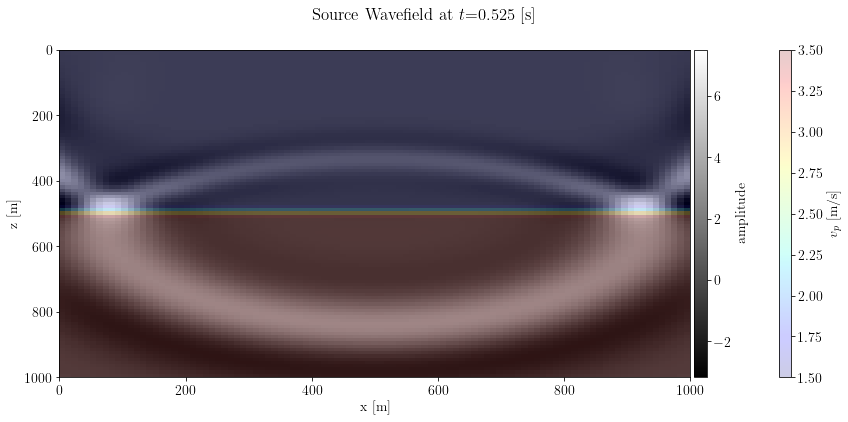

In [10]:
t = 300
fig, axs = plt.subplots(1, 1, figsize=(12,6), sharey=True)
i1 = axs.imshow(unpad(B.src_wfld.data[t]).T, extent=model_extent)
i2 = axs.imshow(unpad(B.velocity[:]).T, cmap="jet", alpha=0.2, extent=model_extent)
axs.set_xlabel(B.velocity.ax_info[0].l)
axs.set_ylabel(B.velocity.ax_info[1].l)
divider = make_axes_locatable(axs)
c1 = divider.append_axes("right", size="2%", pad=0.05)
c2 = divider.append_axes("right", size="2%", pad=1)
plt.colorbar(i1, cax=c1, label="amplitude")
plt.colorbar(i2, cax=c2, label=r"$v_p$ [m/s]")
fig.suptitle(r"Source Wavefield at $t$=%s [s]" % (B.geometry.t0 + t * B.geometry.dt / 1000))
plt.tight_layout()
plt.show()

### Migration

In [11]:
m = B.T * csg_nonlinear

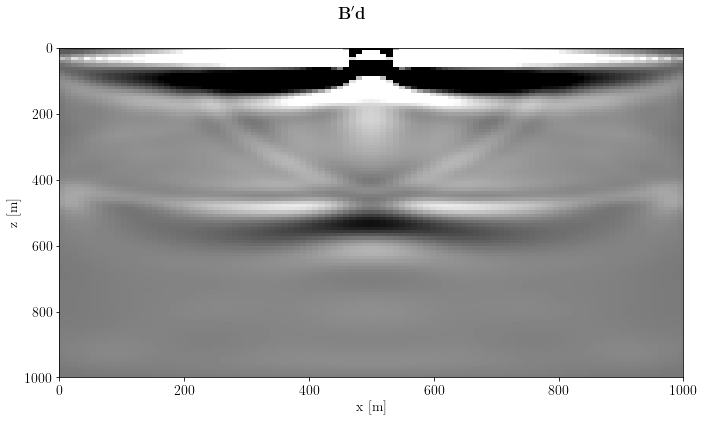

In [12]:
fig, axs = plt.subplots(1, 1, sharey=True)
axs.imshow(unpad(m).T, clim=o.plot.clim(m[:]), extent=model_extent)
axs.set_xlabel(m.ax_info[0].l)
axs.set_ylabel(m.ax_info[1].l)
fig.suptitle(r"$\mathbf{B}'\mathbf{d}$")
plt.tight_layout()
plt.show()

For the sake of completeness, let's see how the linear data look like

In [13]:
img = o.VectorNumpy(model_true.vp.data.__array__() - model_smooth.vp.data.__array__())
d = B * img

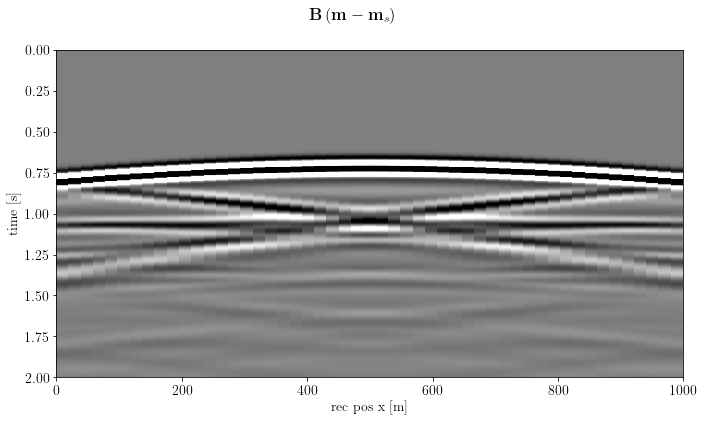

In [14]:
fig, axs = plt.subplots(1, 1, sharey=True)
axs.imshow(d.plot(), clim=o.plot.clim(d[:]),
           extent=[d.ax_info[1].o, d.ax_info[1].last, d.ax_info[0].last, d.ax_info[0].o])
axs.set_xlabel(d.ax_info[1].l)
axs.set_ylabel(d.ax_info[0].l)
fig.suptitle(r"$\mathbf{B}\left(\mathbf{m} - \mathbf{m}_s \right)$")
plt.tight_layout()
plt.show()

##  Case 2: multiple shots

In this case, we distribute each shot to a worker with Dask.

In [15]:
src = [b.build_src_coordinates(x, args["src_depth"]) for x in args["src_x"]]

instantiate Dask client

In [16]:
client = o.DaskClient(local_params={"processes": True}, n_wrks=args["workers"])
print("%d workers instantiated: %s" % (client.num_workers, client.WorkerIds))
print("If you have bokeh installed, you can monitor Dask at %s" % client.dashboard_link)

3 workers instantiated: ['tcp://127.0.0.1:49464', 'tcp://127.0.0.1:49467', 'tcp://127.0.0.1:49469']
If you have bokeh installed, you can monitor Dask at http://127.0.0.1:8787/status


In [17]:
# define how many shots will be processed by each worker:
chunks = args["chunks"] if args["chunks"] is not None else tuple([1] * len(src))
if len(chunks) != client.num_workers:
    raise ValueError("Provided chunks has to fit with client number of workers")
if sum(chunks) != len(src):
    raise UserWarning("Not all shots will be distributed")
    
print("Number of shots for each worker: ", chunks)

Number of shots for each worker:  (1, 1, 1)


### Instantiate the Born operator

In [18]:
B = o.DaskOperator(dask_client=client,
                   chunks=chunks,
                   op_constructor=b.BornSingleSource,
                   op_args=[(v, s, r, a) for v, s, r, a in zip([model_smooth] * len(chunks),
                                                               src,
                                                               [rec] * len(chunks),
                                                               [args] * len(chunks))])

we need also a Spread operator to spread models to workers, and "stack" the images back

In [19]:
B *= o.DaskSpread(dask_client=client, chunks=chunks, domain=model.clone())

### create the common shot gather (CSG) data

In [20]:
csg_nonlinear = b.propagate_shots(model=model_true, src_pos=src, rec_pos=rec, param=args)

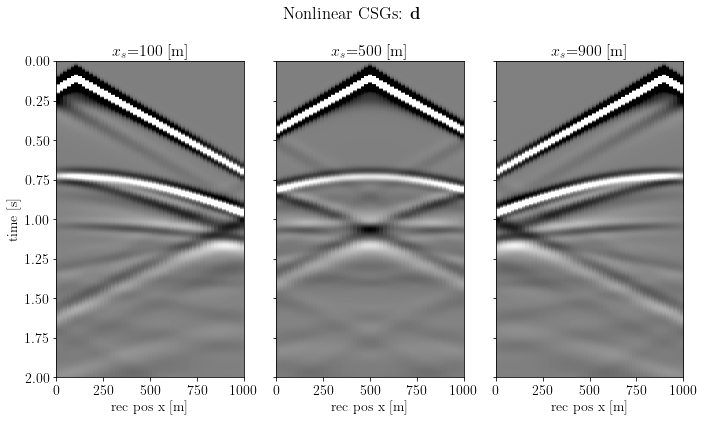

In [21]:
fig, axs = plt.subplots(1, csg_nonlinear.n, sharey=True)
for shot in range(csg_nonlinear.n):
    _ = csg_nonlinear[shot]
    axs[shot].imshow(_.plot(), clim=o.plot.clim(_.plot()),
                     extent=[_.ax_info[1].o, _.ax_info[1].last, _.ax_info[0].last, _.ax_info[0].o])
    axs[shot].set_xlabel(_.ax_info[1].l)
    if shot == 0:
        axs[shot].set_ylabel(_.ax_info[0].l)
    axs[shot].set_title("$x_s$=%.0f [m]" % (src[shot][0, 0]))
    fig.suptitle(r"Nonlinear CSGs: $\mathbf{d}$")
plt.tight_layout()
plt.show()

muting the direct arrival can be done by analytically computing the direct arrival to mask the data

In [22]:
_da_mask = o.superVector([b.direct_arrival_mask(g, src_pos=s, rec_pos=rec, vel_sep=1500., offset=0.35)
                          for g, s in zip(csg_nonlinear.vecs, src)])

csg_muted = csg_nonlinear.clone().multiply(_da_mask)

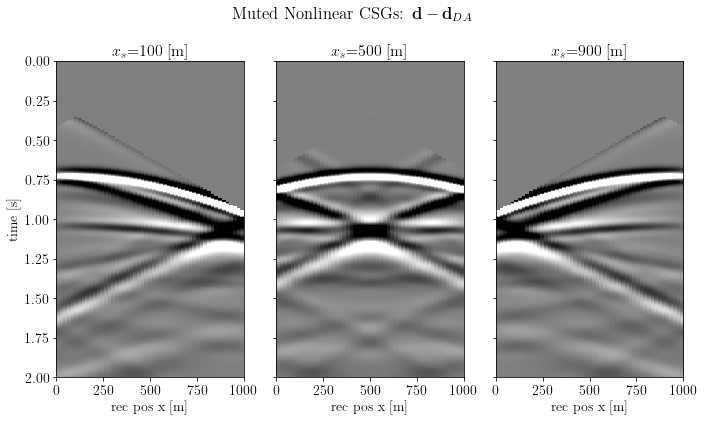

In [23]:
fig, axs = plt.subplots(1, csg_muted.n, sharey=True)
for shot in range(csg_muted.n):
    _ = csg_muted[shot]
    axs[shot].imshow(_.plot(), clim=o.plot.clim(_.plot()),
                     extent=[_.ax_info[1].o, _.ax_info[1].last, _.ax_info[0].last, _.ax_info[0].o])
    axs[shot].set_xlabel(_.ax_info[1].l)
    if shot == 0:
        axs[shot].set_ylabel(_.ax_info[0].l)
    axs[shot].set_title("$x_s$=%.0f [m]" % (src[shot][0, 0]))
    fig.suptitle(r"Muted Nonlinear CSGs: $\mathbf{d} - \mathbf{d}_{DA}$")
plt.tight_layout()
plt.show()

Finally, distribute the data to Dask

In [24]:
csg_ = o.DaskVector(client, vectors=csg_muted.vecs, chunks=args["chunks"])

In [25]:
imaging_label = r"$\mathbf{B}' \left(\mathbf{d} - \mathbf{d}_{DA}\right)$"
inverse_label = r"$\mathbf{B}^{-1} \left(\mathbf{d} - \mathbf{d}_{DA}\right)$"

### Migration

In [26]:
image = B.T * csg_

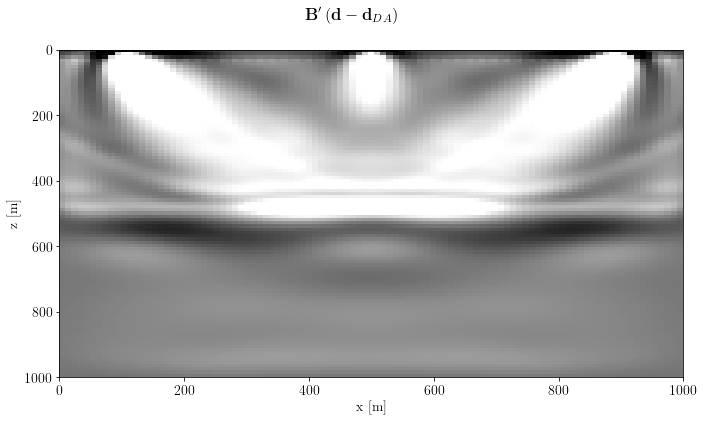

In [27]:
fig, axs = plt.subplots(1, 1, sharey=True)
axs.imshow(unpad(image).T, clim=o.plot.clim(image[:]), extent=model_extent)
axs.set_xlabel(image.ax_info[0].l)
axs.set_ylabel(image.ax_info[1].l)
fig.suptitle(imaging_label)
plt.tight_layout()
plt.show()

create a post-processing operator: apply a gain with depth $\mathbf{G}_z$ and a Laplacian filter $\mathbf{L}$

In [28]:
G = o.Diagonal(b.depth_compensation_mask(model, 1.5))
L = o.SecondDerivative(model, axis=1, sampling=args["spacing"][1])

gain_label = r"$\mathbf{G}_z$"
lapl_label = r"$\mathbf{L}$"

In [29]:
image_post = G * L * image

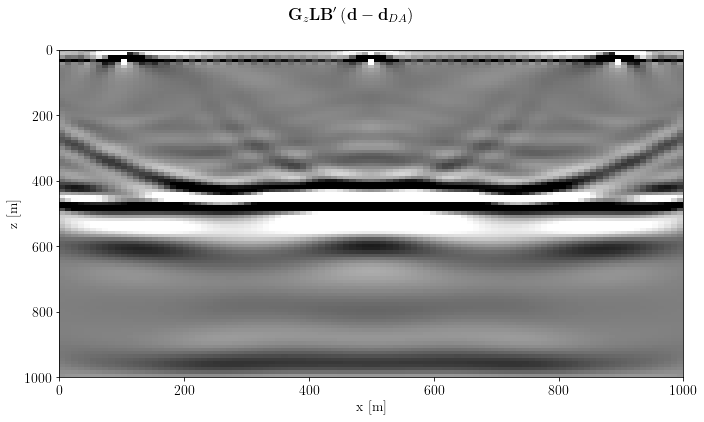

In [30]:
fig, axs = plt.subplots(1, 1, sharey=True)
axs.imshow(unpad(image_post).T, clim=o.plot.clim(image_post[:]), extent=model_extent)
axs.set_xlabel(image_post.ax_info[0].l)
axs.set_ylabel(image_post.ax_info[1].l)
fig.suptitle(gain_label+lapl_label+imaging_label)
plt.tight_layout()
plt.show()

### Least-Squares!
Thanks to OccamyPy we can add also an (anisotropic) total variation regularization in $\ell_1$

Under the assumption that our reflectors are almost flat, we define an unbalanced TV, in which the x-derivative is stronger than the z-derivative.

In [31]:
R = o.Vstack(10 * o.FirstDerivative(model.clone(), axis=0, sampling=args["spacing"][0]),
                  o.FirstDerivative(model.clone(), axis=1, sampling=args["spacing"][1]))

Instantiate the L1-regularized problem, known as `GeneralizedLasso`

In [32]:
problem = o.GeneralizedLasso(model.clone().zero(), csg_, B, reg=R, eps=1e2)
problem.name = "TV-L1 LS-RTM (3 shots)"

Instantiate the Split-Bregman solver

In [33]:
solver = o.SplitBregman(o.BasicStopper(niter=10), niter_inner=3, niter_solver=3,
                        linear_solver='LSQR', breg_weight=1., warm_start=True)

In [34]:
solver.setDefaults(save_obj=True)

Now, solve for real!
Don't forget to check the Dask dashboard!

In [35]:
solver.run(problem, verbose=True, inner_verbose=False)

##########################################################################################
            SPLIT-BREGMAN Solver
    Restart folder: /tmp/restart_2022-04-25T19-24-06.830017/
    Inner iterations: 3
    Solver iterations: 3
    Problem: TV-L1 LS-RTM (3 shots)
    L1 Regularizer weight: 1.00e+02
    Bregman update weight: 1.00e+00
    Using warm start option for inner problem
##########################################################################################

iter = 00, obj = 8.43233e+03, df_obj = 8.43e+03, reg_obj = 0.00e+00, rnorm = 1.30e+02
iter = 01, obj = 6.89802e+03, df_obj = 3.30e+03, reg_obj = 3.60e+03, rnorm = 8.12e+01
iter = 02, obj = 7.64437e+03, df_obj = 2.72e+03, reg_obj = 4.93e+03, rnorm = 7.37e+01
iter = 03, obj = 8.08229e+03, df_obj = 2.44e+03, reg_obj = 5.64e+03, rnorm = 6.99e+01
iter = 04, obj = 8.38706e+03, df_obj = 2.28e+03, reg_obj = 6.11e+03, rnorm = 6.75e+01
iter = 05, obj = 8.53805e+03, df_obj = 2.17e+03, reg_obj = 6.37e+03, rnorm = 6.59e+01
iter

Let's check the objective function terms

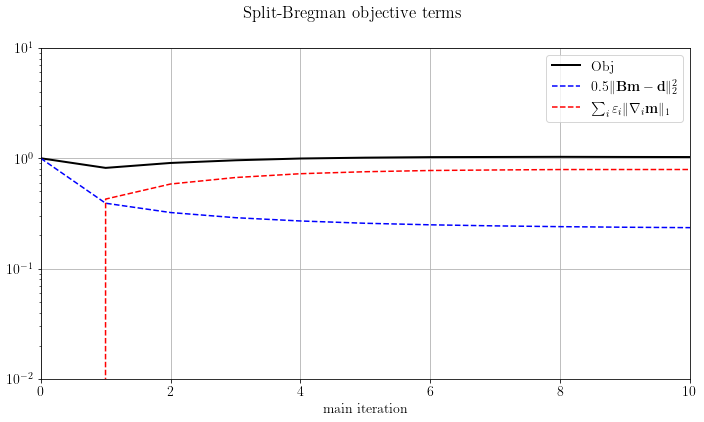

In [36]:
fig, axs = plt.subplots(1, 1, sharey=True)
axs.semilogy(solver.obj / solver.obj[0], 'k', lw=2, label='Obj')
axs.semilogy(solver.obj_terms[:, 0] / solver.obj[0], 'b--', label=r"$0.5 \Vert \mathbf{Bm-d} \Vert_2^2$")
axs.semilogy(solver.obj_terms[:, 1] / solver.obj[0], 'r--',
             label=r"$\sum_i\varepsilon_i \Vert \nabla_i\mathbf{m}\Vert_1$")
axs.legend(), axs.grid(True)
axs.set_xlim(0, solver.stopper.niter), axs.set_ylim(1e-2, 1e1)
axs.set_xlabel("main iteration")
plt.suptitle("Split-Bregman objective terms")
plt.tight_layout()
plt.show()

Now check the result

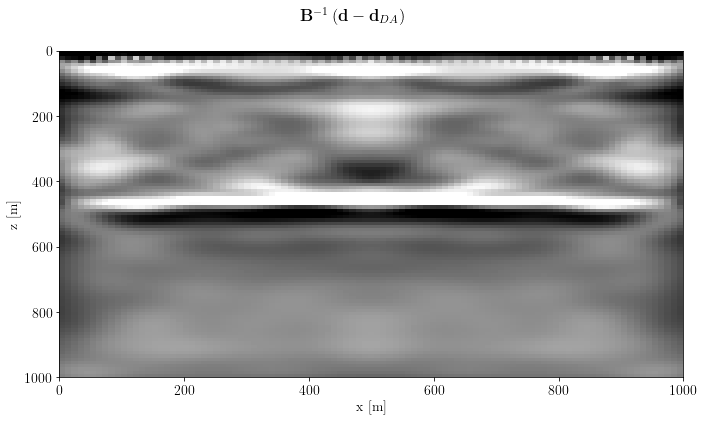

In [37]:
fig, axs = plt.subplots(1, 1, sharey=True)
axs.imshow(unpad(problem.model).T, clim=o.plot.clim(problem.model[:]), extent=model_extent)
axs.set_xlabel(image.ax_info[0].l)
axs.set_ylabel(image.ax_info[1].l)
fig.suptitle(inverse_label)
plt.tight_layout()
plt.show()

Finally, apply the  post-processing operator

In [38]:
img_inv_post = G * L * problem.model

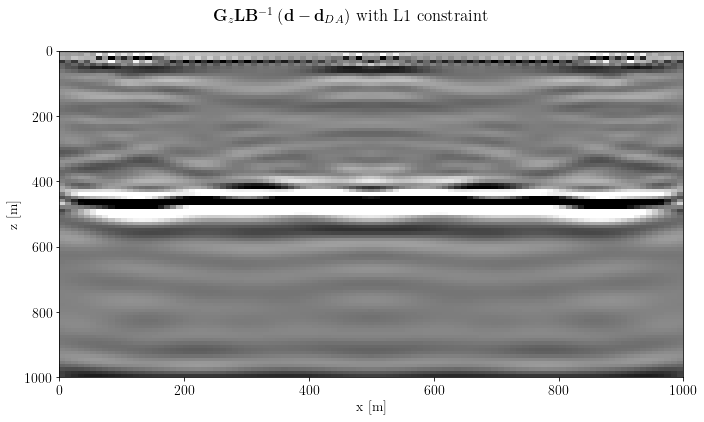

In [39]:
fig, axs = plt.subplots(1, 1, sharey=True)
axs.imshow(unpad(img_inv_post).T, clim=o.plot.clim(img_inv_post[:]), extent=model_extent)
axs.set_xlabel(img_inv_post.ax_info[0].l)
axs.set_ylabel(img_inv_post.ax_info[1].l)
fig.suptitle(gain_label+lapl_label+inverse_label + " with L1 constraint")
plt.tight_layout()
plt.show()

### Compare sparsity promoting result with simple CG inversion

Let's now compare the result we obtained with Split-Bregman with the simpler CG with  the same number of linear inversion iterations (approx. the same time).

In [40]:
problem_cg = o.LeastSquares(model.clone().zero(), csg_, B)
problem_cg.name = "LS-RTM (3 shots)"

In [41]:
cg = o.CG(o.BasicStopper(niter=int(solver.stopper.niter * solver.niter_inner * solver.niter_solver)))

In [42]:
cg.stopper.niter

90

In [43]:
cg.setDefaults(save_obj=True)

In [44]:
cg.run(problem_cg, verbose=True)

##########################################################################################
            CG Solver
    Restart folder: /tmp/restart_2022-04-25T19-25-59.037417/
    Problem: LS-RTM (3 shots)
##########################################################################################

iter = 00, obj = 8.43233e+03, rnorm = 1.30e+02, gnorm = 7.35e+03, feval = 002
iter = 01, obj = 6.07498e+03, rnorm = 1.10e+02, gnorm = 3.53e+03, feval = 004
iter = 02, obj = 5.52355e+03, rnorm = 1.05e+02, gnorm = 3.83e+03, feval = 006
iter = 03, obj = 4.52681e+03, rnorm = 9.52e+01, gnorm = 2.48e+03, feval = 008
iter = 04, obj = 4.04192e+03, rnorm = 8.99e+01, gnorm = 1.98e+03, feval = 010
iter = 05, obj = 3.49174e+03, rnorm = 8.36e+01, gnorm = 1.37e+03, feval = 012
iter = 06, obj = 3.16442e+03, rnorm = 7.96e+01, gnorm = 1.24e+03, feval = 014
iter = 07, obj = 2.90649e+03, rnorm = 7.62e+01, gnorm = 1.24e+03, feval = 016
iter = 08, obj = 2.69179e+03, rnorm = 7.34e+01, gnorm = 1.28e+03, feval = 018
it

In [45]:
cg_img_inv_post = G * L * problem_cg.model

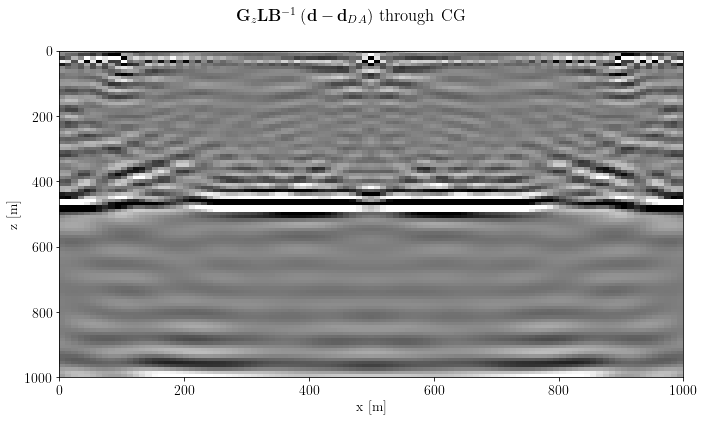

In [46]:
fig, axs = plt.subplots(1, 1, sharey=True)
axs.imshow(unpad(cg_img_inv_post).T, clim=o.plot.clim(cg_img_inv_post[:]), extent=model_extent)
axs.set_xlabel(cg_img_inv_post.ax_info[0].l)
axs.set_ylabel(cg_img_inv_post.ax_info[1].l)
fig.suptitle(gain_label+lapl_label+inverse_label + " through CG")
plt.tight_layout()
plt.show()